In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from itertools import product
from matplotlib import pyplot as plt

Координаты прямоугольника Нью-Йорка.

In [2]:
north_lat = 40.91553
south_lat = 40.49612
west_long = -74.25559
east_long = -73.70001

# Загрузка и обработка данных

In [3]:
data = pd.read_csv('yellow_tripdata_2016-05.csv')

In [4]:
data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2016-05-01 00:00:00,2016-05-01 00:17:31,1,3.60,-73.985901,40.768040,1,N,-73.983986,40.730099,1,15.0,0.5,0.5,1.50,0.0,0.3,17.80
1,2,2016-05-01 00:00:00,2016-05-01 00:07:31,1,1.68,-73.991577,40.744751,1,N,-73.975700,40.765469,1,7.5,0.5,0.5,0.88,0.0,0.3,9.68
2,2,2016-05-01 00:00:00,2016-05-01 00:07:01,6,1.09,-73.993073,40.741573,1,N,-73.980995,40.744633,1,6.5,0.5,0.5,1.56,0.0,0.3,9.36
3,2,2016-05-01 00:00:00,2016-05-01 00:19:47,1,4.21,-73.991943,40.684601,1,N,-74.002258,40.733002,1,17.0,0.5,0.5,3.66,0.0,0.3,21.96
4,2,2016-05-01 00:00:00,2016-05-01 00:06:39,1,0.56,-74.005280,40.740192,1,N,-73.997498,40.737564,1,6.0,0.5,0.5,1.46,0.0,0.3,8.76


In [5]:
len(data)

11836853

Перевод столбцов tpep_pickup_datetime и tpep_dropoff_datetime из текстового формата String во времянной формат Timestamp.

In [6]:
data['tpep_pickup_datetime'] = pd.to_datetime(data['tpep_pickup_datetime'])
data['tpep_dropoff_datetime'] = pd.to_datetime(data['tpep_dropoff_datetime'])

Удаление поездок нулевой длительности.

In [7]:
data = data.drop(data[data['tpep_dropoff_datetime'] == data['tpep_pickup_datetime']].index)

In [8]:
len(data)

11824585

Удаление поездок с нулевым количеством пассажиров.

In [9]:
data = data.drop(data[data['passenger_count'] == 0].index)

In [10]:
len(data)

11824063

Удаление поездок нулевой расстоянием поездки по счётчику.

In [11]:
data = data.drop(data[data['trip_distance'] == 0].index)

In [12]:
len(data)

11763422

Удаление поездок, начинающихся за пределами прямоугольника Нью-Йорка.

In [13]:
data = data.drop(data[(data['pickup_latitude'] >= north_lat) | (data['pickup_latitude'] <= south_lat) | (data['pickup_longitude'] <= west_long) | (data['pickup_longitude'] >= east_long)].index)

In [14]:
len(data)

11626521

#  Подсчет поездок в пространстве и времени

Построение пространственной сетки. Разбиение прямоугольника Нью-Йорка на 2500 секторов: 50 делений по долготе и 50 делений по широте.

In [15]:
long_segm_count = 50
lat_segm_count = 50
long_grid = np.linspace(west_long, east_long, long_segm_count + 1)
lat_grid = np.linspace(south_lat, north_lat, long_segm_count + 1)

In [16]:
sectors_coordinates = []
for i in range(len(long_grid) - 1):
    for j in range(len(lat_grid) - 1):
        sectors_coordinates.append([long_grid[i], long_grid[i + 1], lat_grid[j], lat_grid[j + 1]])
sectors_coordinates = np.array(sectors_coordinates)

Функция, определяющая номер сектора, в который попадают данные координаты.

In [17]:
def identify_sector(coord):
    lon = coord[0]
    lat = coord[1]
    # Определение номера деления, в которое попадают координаты по долготе
    long_dist_to_bord = long_grid - lon
    long_nearest_bord_inx = np.argmin(abs(long_dist_to_bord))
    if long_dist_to_bord[long_nearest_bord_inx] < 0:
        long_coord_segm = long_nearest_bord_inx
    else:
        long_coord_segm = long_nearest_bord_inx - 1
    # Определение номера деления, в которое попадают координаты по широте
    lat_dist_to_bord = lat_grid - lat
    lat_nearest_bord_inx = np.argmin(abs(lat_dist_to_bord))
    if lat_dist_to_bord[lat_nearest_bord_inx] < 0:
        lat_coord_segm = lat_nearest_bord_inx
    else:
        lat_coord_segm = lat_nearest_bord_inx - 1
    # Определение номера сектора
    return long_coord_segm * lat_segm_count + lat_coord_segm + 1

Построение времянной сетки. Разбиение времяни по часам.

In [18]:
time_max = max(data['tpep_pickup_datetime'].values)
time_min = min(data['tpep_pickup_datetime'].values)

In [19]:
hours_count = np.ceil((time_max - time_min) / np.timedelta64(1, 'h'))

In [20]:
time_grid = []
for i in range(int(hours_count + 1)):
    time_grid.append(time_min + i * np.timedelta64(1, 'h'))

Обработка координат начала поездок. Присвоение номера сектора начала поездки каждой поездке.

In [21]:
loc_data = data[['pickup_longitude', 'pickup_latitude']]

In [22]:
loc_data['sector_num'] = map(identify_sector, loc_data.values)

/opt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [23]:
loc_data.head()

,pickup_longitude,pickup_latitude,sector_num
0,-73.985901,40.768040,1233
1,-73.991577,40.744751,1180
2,-73.993073,40.741573,1180
3,-73.991943,40.684601,1173
4,-74.005280,40.740192,1130


Подсчет поездок из каждого сектора и в каждый час: заполнение 2d-гистограммы.

In [24]:
sectors = loc_data['sector_num'].values
times = data['tpep_pickup_datetime'].values
sectors_bins = range(1, long_segm_count * lat_segm_count + 2)
times_bins = time_grid
ride_hist = np.histogram2d(sectors, times, bins=[sectors_bins, times_bins])[0]

Составление таблицы количества поездок в каждом секторе, за каждый час. 

In [25]:
sectors_times_prod = np.array(zip(product(sectors_bins[:-1], times_bins[:-1])))[:, 0]

In [26]:
ride_tipe_count = pd.DataFrame({'sector_num': sectors_times_prod[:, 0],
                                'time': sectors_times_prod[:, 1],
                                'ride_count': np.int32(ride_hist.flatten())})

In [27]:
ride_tipe_count.head()

,ride_count,sector_num,time
0,0,1,2016-05-01 00:00:00
1,0,1,2016-05-01 01:00:00
2,0,1,2016-05-01 02:00:00
3,0,1,2016-05-01 03:00:00
4,0,1,2016-05-01 04:00:00


# График количества поездок от времени в секторе с Empire State Building

Координаты Empire State Building:

In [28]:
ESB_long = -73.985428
ESB_lat = 40.748817

Определение номера сектора, в котором расположен Empire State Building.

In [29]:
ESB_sect_num = identify_sector((ESB_long, ESB_lat))
print 'Номер сектора, в котором расположен Empire State Building:', ESB_sect_num

Номер сектора, в котором расположен Empire State Building: 1231


Построение графика количества поездок от времени в секторе с Empire State Building.

In [30]:
ESB_ride_count_table = ride_tipe_count[ride_tipe_count['sector_num'] == ESB_sect_num][['ride_count', 'time']]

In [31]:
ESB_ride_count_table.head()

,ride_count,time
915120,881,2016-05-01 00:00:00
915121,713,2016-05-01 01:00:00
915122,533,2016-05-01 02:00:00
915123,418,2016-05-01 03:00:00
915124,353,2016-05-01 04:00:00


/opt/anaconda2/lib/python2.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0,0.5,u'\u041a\u043e\u043b\u0438\u0447\u0435\u0441\u0442\u0432\u043e \u043f\u043e\u0435\u0437\u0434\u043e\u043a \u0437\u0430 \u0447\u0430\u0441')

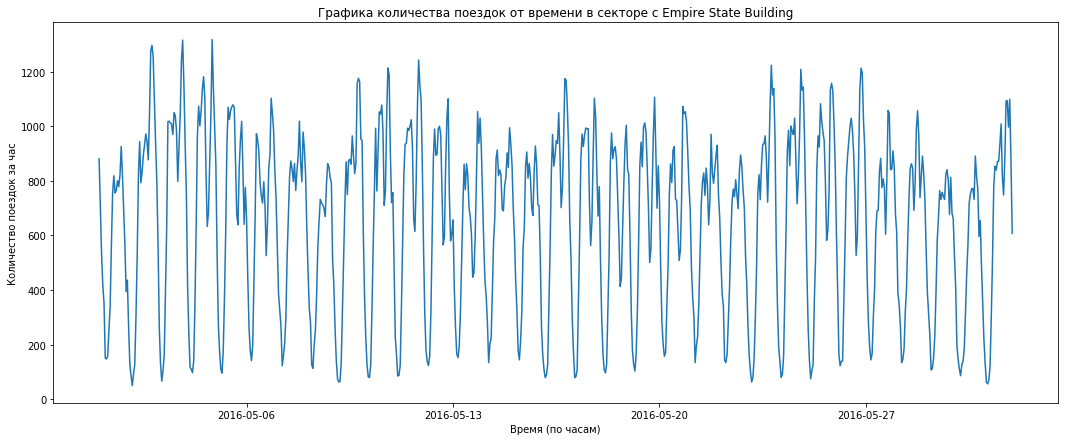

In [32]:
plt.figure(figsize=(18, 7))
plt.plot(ESB_ride_count_table['time'], ESB_ride_count_table['ride_count'])
plt.title(u'Графика количества поездок от времени в секторе с Empire State Building')
plt.xlabel(u'Время (по часам)')
plt.ylabel(u'Количество поездок за час')

# Подсчет пар час-ячейка, для которых не было совершено ни одной поездки

In [33]:
print 'Колличество пар час-ячейка, для которых не было совершено ни одной поездки:', len(np.where(ride_hist == 0)[0])

Колличество пар час-ячейка, для которых не было совершено ни одной поездки: 1718238
